In [69]:
import sys
import json
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from Bio import SeqIO
import json
from sklearn.feature_extraction.text import CountVectorizer
from toolz import partition_all
from joblib import Parallel, delayed
from nltk.corpus import stopwords
import pickle
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
import glob
from sklearn.utils import shuffle
import sys
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import StandardScaler
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import glob
import time
import string
from nltk.corpus import stopwords
stoplist = set(stopwords.words("english"))
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
from nltk import ngrams
from nltk.classify import NaiveBayesClassifier


In [5]:
def read_bin(binnum):
    bindata = []
    files = set(glob.glob('/home/anamikas/work/fungcat_threat/bin{}*'.format(binnum)))
    files2ignore = set(glob.glob('/home/anamikas/work/fungcat_threat/bin{}*85*'.format(binnum)))
    
    expandedtruth = set(glob.glob("/home/anamikas/work/fungcat_threat/bin{}*Uniref*".format(binnum)))
    
    ids = []
    for fl in (files - files2ignore - expandedtruth):
        with open(fl) as inf:
            tmp = [json.loads(l) for l in inf]
            bindata += tmp
            ids += [_['_id'] for _ in tmp]
                
    binexpanded = []
    ids = set(ids)
    for fl in (expandedtruth - files2ignore):
        with open(fl) as inf:
            tmp = [json.loads(l) for l in inf]
            onlyexpdocs = [_ for _ in tmp  if _['_id'] not in ids]
            binexpanded += onlyexpdocs
 
    return bindata, binexpanded

In [6]:
def get_id(bindata, label):
    return {doc['_id']: label for doc in bindata}

In [7]:
bin1, bin1exp = read_bin(1)
bin2, bin2exp = read_bin(2)
bin3, bin3exp = read_bin(3)
bin4, bin4exp = read_bin(4)
with open("/home/anamikas/work/AllDocuments_9585_processed_sentences.pkl", "rb") as inf:
    docs = pickle.load(inf)

In [8]:
len(bin1)+len(bin1exp)+len(bin2)+len(bin2exp)

5632

In [9]:
len(bin3)+len(bin3exp)+len(bin4)+len(bin4exp)

4973

In [10]:
expid2clf = get_id(bin1exp, 1)
expid2clf.update(get_id(bin2exp, 2))
expid2clf.update(get_id(bin3exp, 3))
expid2clf.update(get_id(bin4exp, 4))


id2clf = get_id(bin1, 1)
id2clf.update(get_id(bin2, 2))
id2clf.update(get_id(bin3, 3))
id2clf.update(get_id(bin4, 4))


In [11]:
alldocs = docs
docs = [l for l in alldocs if l['id'] in id2clf]
docs_exp = [l for l in alldocs if l['id'] in expid2clf and l['id'] not in id2clf]


In [13]:
print(len(alldocs), len(docs), len(docs_exp))

10908 364 10408


In [14]:
5632+4973

10605

In [37]:
class_0 = []
class_1 = []

In [38]:
def addpubmedArticles(bin):
    result = []
    for items in bin:
        if 'AB' in items['pubmed'][0].keys():
            result.append(items)
    return result

In [39]:
class_0.extend(addpubmedArticles(bin1))
class_0.extend(addpubmedArticles(bin1exp))
class_0.extend(addpubmedArticles(bin2))
class_0.extend(addpubmedArticles(bin2exp))
class_1.extend(addpubmedArticles(bin3))
class_1.extend(addpubmedArticles(bin3exp))
class_1.extend(addpubmedArticles(bin4))
class_1.extend(addpubmedArticles(bin4exp))

In [40]:
print(len(class_0), len(class_1))

5587 4947


In [45]:
class_0_dict = {}
class_1_dict = {}

In [46]:
for i, items in enumerate(class_0):
    class_0_dict[i] = items['pubmed'][0]['AB']

In [48]:
for i, items in enumerate(class_1):
    class_1_dict[i] = items['pubmed'][0]['AB']

In [56]:
def create_ngram_features(words, n=2):
    #strip useless end punctuations
    useful_words = [word[:-1] for word in words.split(" ") if word.endswith(".") or word.endswith(";") or word.endswith(":") or word.endswith(",")]
    #string punctuations
    useful_words = [word for word in useful_words if word not in string.punctuation]
    #strip useless charaters
    useful_words = [word.strip('\n') for word in useful_words]
    #remove stop words
    useful_words = [word.lower() for word in useful_words if word not in stoplist]
    #lemmatize
    useful_words = [lmtzr.lemmatize(word) for word in useful_words]
    words = " "
    words = " ".join(word for word in useful_words)
    ngram_vocab = ngrams(useful_words, n)
    my_dict = dict([(ng, True) for ng in ngram_vocab])
    return my_dict

In [57]:
def callRemoveExtra(greater, smaller):
    extra = len(greater)-len(smaller)
    while extra:
        greater.pop()
        extra -= 1
    return greater

In [72]:
start_0 = time.time()
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    
    print("Creating ", str(n), " grams")
    
    class0_data = []
    for key, text in class_0_dict.items():
        class0_data.append((create_ngram_features(text, n), "class0"))    

    class1_data = []
    for key, text in class_1_dict.items():
        class1_data.append((create_ngram_features(text, n), "class1"))    
    
    shuffle(class0_data)
    shuffle(class1_data)
    
    if len(class0_data)>len(class1_data):
        class0_data = callRemoveExtra(class0_data, class1_data)
    else:
        class1_data = callRemoveExtra(class1_data, class0_data)
        
    limit = round(0.8*len(class0_data))
    
    train_set = class0_data[:limit] + class1_data[:limit]
    test_set =  class0_data[limit:] + class1_data[limit:]
    
    print("Training")
    
    start = time.time()
    classifier = NaiveBayesClassifier.train(train_set)
    end = time.time()
    print("Time taken", end-start)
    
    print("Training done")
    
    print("Testing for test dataset")
    
    start = time.time()
    accuracy = nltk.classify.util.accuracy(classifier, test_set)
    end = time.time()
    print("Time taken", end-start)
    
    print(str(n)+'-gram accuracy for test:', accuracy)
    
    print(classifier.show_most_informative_features(10))
    
end_0 = time.time()
print(end_0-start_0)
print("Total time taken")

Creating  1  grams
Training
Time taken 0.5098719596862793
Training done
Testing for test dataset
Time taken 0.17818117141723633
1-gram accuracy for test: 0.5136501516683518
Most Informative Features
            ('carrier',) = True           class1 : class0 =    346.3 : 1.0
             ('cohort',) = True           class1 : class0 =    147.0 : 1.0
               ('load',) = True           class1 : class0 =    141.7 : 1.0
       ('immunization',) = True           class1 : class0 =    107.0 : 1.0
                ('pb1',) = True           class0 : class1 =    105.0 : 1.0
            ('therapy',) = True           class1 : class0 =     87.0 : 1.0
                 ('a1',) = True           class1 : class0 =     73.7 : 1.0
             ('europe',) = True           class0 : class1 =     71.8 : 1.0
           ('enrolled',) = True           class1 : class0 =     71.7 : 1.0
                 ('b3',) = True           class1 : class0 =     65.7 : 1.0
None
Creating  2  grams
Training
Time taken 1.72900

/home/anamikas/anaconda3/envs/hyp/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: generator 'ngrams' raised StopIteration
  from ipykernel import kernelapp as app


Training
Time taken 1.0370795726776123
Training done
Testing for test dataset
Time taken 0.16681361198425293
3-gram accuracy for test: 0.6137512639029322
Most Informative Features
('aivs', 'genome', 'allele') = True           class0 : class1 =     51.8 : 1.0
('health', 'available', 'aivs') = True           class0 : class1 =     51.8 : 1.0
('pandemic', 'health', 'available') = True           class0 : class1 =     51.8 : 1.0
('genotype', 'mutation', 'determinant') = True           class0 : class1 =     51.8 : 1.0
('allele', 'genotype', 'mutation') = True           class0 : class1 =     51.8 : 1.0
('available', 'aivs', 'genome') = True           class0 : class1 =     51.8 : 1.0
('genome', 'allele', 'genotype') = True           class0 : class1 =     51.8 : 1.0
('infection', 'however', 'characterized') = True           class1 : class0 =     17.7 : 1.0
('however', 'unclear', 'study') = True           class1 : class0 =     13.0 : 1.0
('gene', 'however', 'lineage') = True           class0 : cl

Training
Time taken 0.686384916305542
Training done
Testing for test dataset
Time taken 0.12965631484985352
10-gram accuracy for test: 0.5712841253791708
Most Informative Features
('bird', '2013', 'jiangxi', 'market', 'outbreak', 'virus', 'isolate', 'infection', 'recently', 'reassorted') = True           class0 : class1 =     12.7 : 1.0
('2013', 'jiangxi', 'market', 'outbreak', 'virus', 'isolate', 'infection', 'recently', 'reassorted', 'virus') = True           class0 : class1 =     12.7 : 1.0
('virus', 'variant', 'china', 'importance', 'china', 'reported', 'china', 'lake', 'asia', 'virus') = True           class0 : class1 =     12.7 : 1.0
('variant', 'china', 'importance', 'china', 'reported', 'china', 'lake', 'asia', 'virus', 'market') = True           class0 : class1 =     12.7 : 1.0
('market', 'outbreak', 'virus', 'isolate', 'infection', 'recently', 'reassorted', 'virus', 'variant', 'china') = True           class0 : class1 =     12.7 : 1.0
('china', 'reported', 'china', 'lake', 'a

Plot the frequencies

In [73]:
doc_0 = ""
for items in class_0:
    doc_0 +=  items['pubmed'][0]['AB']

In [74]:
doc_1 = ""
for items in class_1:
    doc_1 +=  items['pubmed'][0]['AB']

In [78]:
#stopwords removal
filtered_doc0 = [word.lower() for word in doc_0.split(" ") if word.lower() not in stopwords.words("english")]
filtered_doc0_stop = filtered_doc0
filtered_doc0 = []
filtered_doc0 = [lmtzr.lemmatize(word) for word in filtered_doc0_stop]
fdist0 = nltk.FreqDist(filtered_doc0)
#Get 50 Most Common Words
print (fdist0.most_common(100))

[('virus', 29263), ('influenza', 13432), ('gene', 9410), ('human', 7628), ('swine', 5004), ('avian', 4731), ('analysis', 4657), ('isolated', 4024), ('h5n1', 3768), ('sequence', 3683), ('isolates', 3582), ('poultry', 3577), ('strain', 3425), ('genetic', 3201), ('duck', 3158), ('lineage', 2911), ('genotype', 2910), ('surveillance', 2889), ('study', 2871), ('china', 2870), ('genome', 2812), ('infection', 2620), ('phylogenetic', 2583), ('different', 2560), ('h9n2', 2560), ('two', 2534), ('domestic', 2522), ('pandemic', 2428), ('showed', 2336), ('bird', 2322), ('chicken', 2285), ('reassortment', 2217), ('may', 2178), ('segment', 2124), ('viral', 1963), ('emergence', 1931), ('southern', 1926), ('north', 1903), ('transmission', 1889), ('host', 1887), ('revealed', 1877), ('also', 1862), ('outbreak', 1853), ('novel', 1848), ('h7n9', 1810), ('new', 1782), ('result', 1765), ('h1n1', 1754), ('acid', 1743), ('potential', 1737), ('multiple', 1721), ('region', 1652), ('aiv', 1649), ('wild', 1641), ('

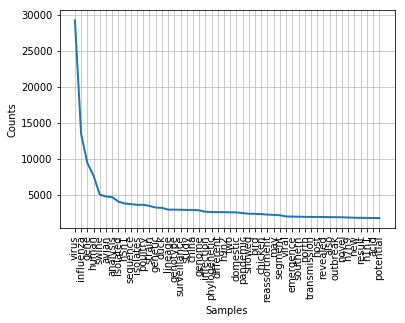

In [80]:
fdist0.plot(50, cumulative=False)

In [81]:
#stopwords removal
filtered_doc1 = [word.lower() for word in doc_1.split(" ") if word.lower() not in stopwords.words("english")]
filtered_doc1_stop = filtered_doc1
filtered_doc1 = []
filtered_doc1 = [lmtzr.lemmatize(word) for word in filtered_doc1_stop]
fdist1 = nltk.FreqDist(filtered_doc1)
#Get 50 Most Common Words
print (fdist1.most_common(100))

[('hbv', 12625), ('virus', 11170), ('genotype', 8509), ('mutation', 8240), ('b', 7472), ('hepatitis', 6517), ('patient', 6462), ('sequence', 4460), ('chronic', 4366), ('analysis', 4296), ('strain', 4235), ('gene', 4040), ('isolates', 3510), ('infection', 3482), ('genome', 3480), ('viral', 3207), ('study', 2871), ('aclf', 2730), ('region', 2713), ('associated', 2524), ('h9n2', 2517), ('among', 2459), ('human', 2427), ('different', 2400), ('showed', 2398), ('influenza', 2380), ('found', 2286), ('sequencing', 2225), ('(hbv)', 2181), ('two', 2019), ('significantly', 1988), ('higher', 1974), ('dna', 1965), ('genetic', 1965), ('core', 1870), ('novel', 1834), ('lineage', 1799), ('may', 1775), ('h7n9', 1739), ('c', 1698), ('case', 1641), ('poultry', 1613), ('deletion', 1589), ('including', 1580), ('phylogenetic', 1537), ('identified', 1527), ('disease', 1496), ('result', 1496), ('complete', 1483), ('nucleotide', 1478), ('liver', 1469), ('risk', 1466), ('china', 1461), ('also', 1441), ('type', 

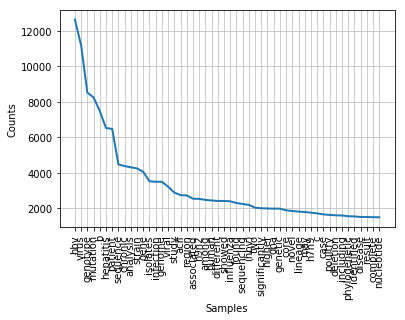

In [82]:
fdist1.plot(50, cumulative=False)

In [85]:
all_0 = set([])
all_1 = set([])
for items in fdist0.most_common(50):
    all_0.add(items[0])

In [88]:
for items in fdist1.most_common(50):
    all_1.add(items[0])

In [89]:
print(all_0.intersection(all_1))

{'sequence', 'novel', 'h9n2', 'gene', 'infection', 'genome', 'may', 'genotype', 'phylogenetic', 'different', 'study', 'lineage', 'showed', 'strain', 'poultry', 'two', 'viral', 'human', 'influenza', 'h7n9', 'virus', 'genetic', 'result', 'analysis', 'isolates'}


In [90]:
print(len(all_0.intersection(all_1)))

25


In [100]:
fdist_0 = fdist0

In [104]:
fdist_0 = []
for item in fdist0.items():
    fdist_0.append(item)

In [117]:
sorted_fdist_0 = sorted(fdist_0, key=lambda x: x[1], reverse=True)

In [112]:
fdist_1 = []
for item in fdist1.items():
    fdist_1.append(item)

In [118]:
sorted_fdist_1 = sorted(fdist_1, key=lambda x: x[1], reverse=True)

In [126]:
len(sorted_fdist_1[-(round(0.1*len(sorted_fdist_1))):])

1938